In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Bitte die Zelle einmal ausführen, um packages zu installieren. Kann dann auch gelöscht werden.
! pip install scikit-image==0.21.0 

In [3]:
from Utils import *
from Evaluation import *
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd

# Hefekulturen

## Define Files to Evaluate

Please edit the path to the reference plate (`path_to_reference_plate`) and experiment plate (`path_to_experiment_plate`) as well as the folder to save the results to (`save_results_folder`)

**Attention** Please make sure that the images are cropped, in such way that only the yeast colonies are visible.

In [4]:
path_to_reference_plate = r"C:\Users\Hannah\Documents\Hefekulturen\Daten\Data_May_2023\Spa2/C_Gen_D3.JPG" #r"./Data\36_MPA_ref_d3.JPG" # 
path_to_experiment_plate = r"C:\Users\Hannah\Documents\Hefekulturen\Daten\Data_May_2023\Spa2/C_Cu50_D3.JPG" #r"./Data\36_MPA_Cu0_d3.JPG"  #

save_results_folder = r"./Results_May2023/Spa2/"

In [5]:
if("A_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 32 
elif("B_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 32 
elif("C_" in Path(path_to_reference_plate).stem):
    x_expected = 48 
    y_expected = 28 

In [6]:
MIN_COLONY_SIZE = 85.0 # this is approximated by the smallest 3% in all plates 
P_VALUE_NULLHYPOTHESIS = 0.01

In [7]:
os.makedirs(save_results_folder, exist_ok=True)

## Open and Preprocess Images

### Open Images as Binary

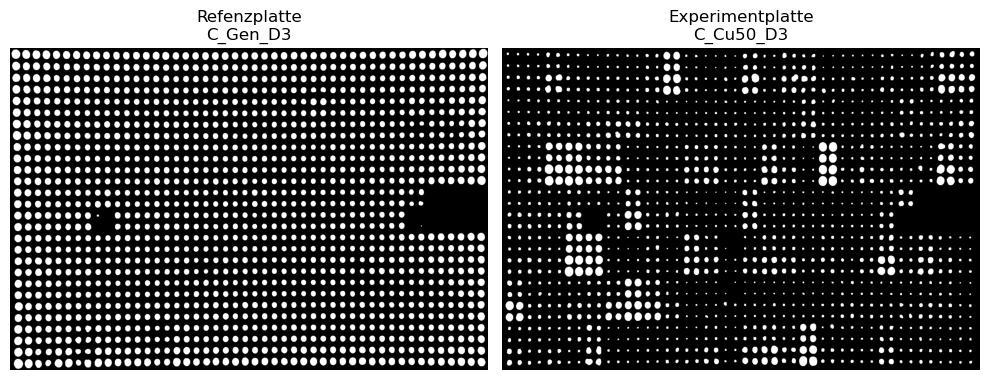

In [8]:
reference_plate = open_image(path_to_reference_plate)
experiment_plate = open_image(path_to_experiment_plate)

fig, axs = plt.subplots(1,2, figsize = (10,10*2))
axs[0].imshow(reference_plate, cmap="gray")
axs[1].imshow(experiment_plate, cmap="gray")
axs[0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
axs[1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.tight_layout()
plt.show()

### Compute Colony Sizes



#### Automatic

Please set `x_expected` to the number of colonies visible in the x-Axis (width) 

Please set `y_expected` to the number of colonies visible in the y-Axis (height) 

Please only set `USE_HARD_GRID` to `True` if the grid is not working properly.

In [9]:
USE_HARD_GRID = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


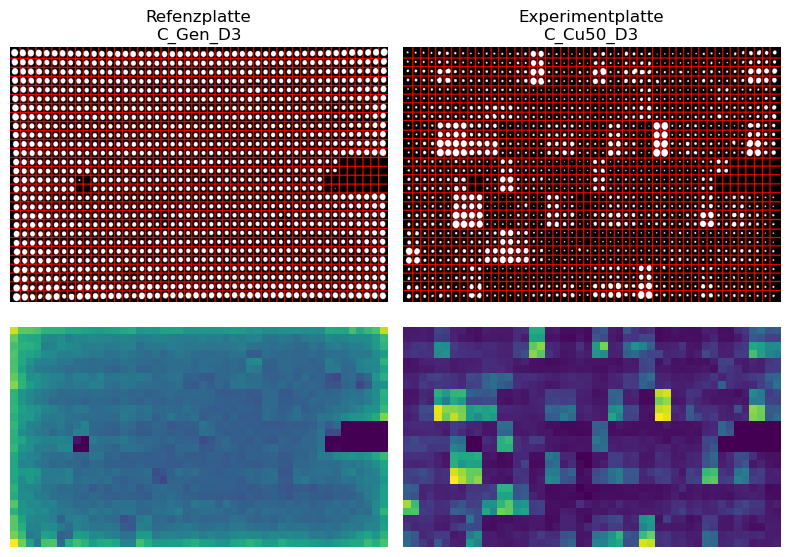

In [10]:
rgb_grid_reference, sizes_reference, x_start, x_end, y_start, y_end = compute_grid(reference_plate, x_expected, y_expected, USE_HARD_GRID, plot = False)
rgb_grid_experiment, sizes_experiment, x_start, x_end, y_start, y_end = compute_grid(experiment_plate, x_expected, y_expected, USE_HARD_GRID, plot = False)

if((not np.any(rgb_grid_reference == None)) and (not np.any(rgb_grid_experiment == None))):
    fig, axs = plt.subplots(2,2, figsize = (4*2,4*1.5))
    axs[0,0].imshow(rgb_grid_reference)
    axs[0,1].imshow(rgb_grid_experiment)
    axs[0,0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
    axs[0,1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
    axs[0,0].set_axis_off()
    axs[0,1].set_axis_off()

    axs[1,0].imshow(sizes_reference) #, cmap= "plasma")
    axs[1,1].imshow(sizes_experiment) #, cmap= "plasma")
    axs[1,0].set_axis_off()
    axs[1,1].set_axis_off()
    plt.tight_layout()
    plt.autoscale(False)
    plt.show()



## Evaluate
- Normalize experimental plate in relation to reference plate
- Find invalid quadruples
- Find siginificant differences between row A and row B
- Find quadruple where either all colonies of the row A quadruple or all colonies of the row B quadruple is larger than median of reference plate
- Saves .pdf into results folder with images

**Open questions: Currently sizes > median of reference plate but probably mean growth of quadruple > than mean growth of corresponting quadruple on the reference plate?**

Therefore adapt `PERCENTILE` to a value in tange 0-100 and test for the best fitting one.

If `PERCENTILE` is set to -1, use outlier detection.

To generate a broad understanding of the p-value and its meaning in statistics, please read: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5665734/

In [11]:
PERCENTILE = -1

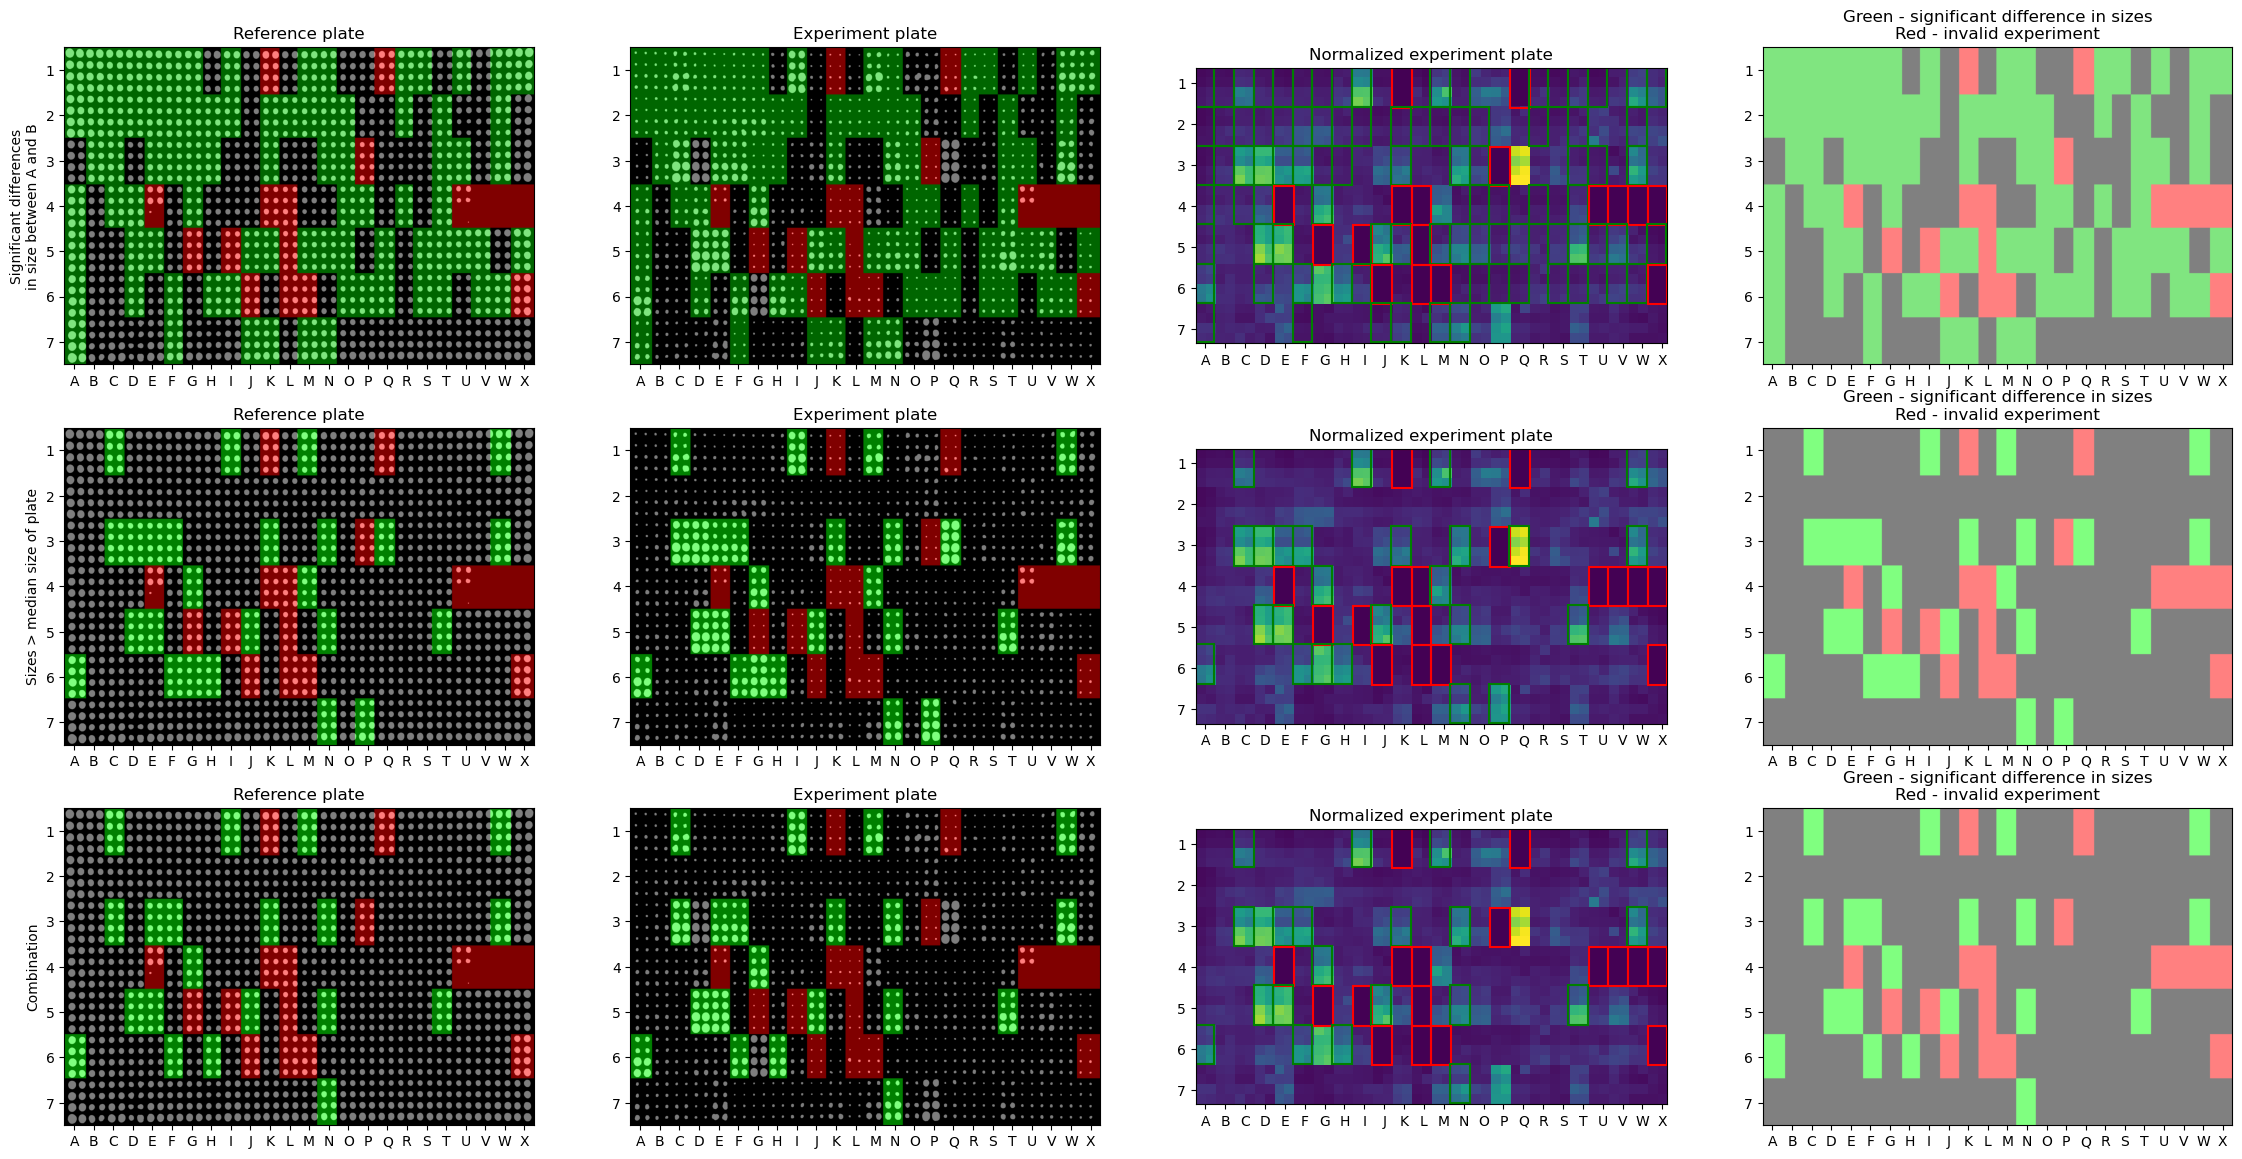

In [12]:
quadruples = evaluate(experiment_plate, reference_plate, sizes_experiment, sizes_reference, x_start, x_end, y_start, y_end, MIN_COLONY_SIZE, P_VALUE_NULLHYPOTHESIS, PERCENTILE, log_dir = save_results_folder+"Result_"+str(Path(path_to_experiment_plate).stem)+".pdf")

## Save Data to Excel Sheet

In [13]:
data = {'position': [quad.position[1]+" "+quad.position[0] for quad in quadruples], 
        'name': [str(quad.name) for quad in quadruples], 
        'p-value': [quad.p_value for quad in quadruples], 
        'effect size': [quad.effect_size for quad in quadruples], 
        'bigger than percentile': [quad.bigger_than_median for quad in quadruples],
        'is valid' : [quad.is_valid for quad in quadruples], 
        'bigger row': [quad.bigger_row for quad in quadruples],

        'diff mean size': [quad.diff_growth for quad in quadruples],        
        'max mean size': [quad.max_mean_growth for quad in quadruples],
        'min mean size': [quad.min_mean_growth for quad in quadruples],
        'sizes A': [str(quad.quadrupelA.sizes) for quad in quadruples], 
        'sizes B': [str(quad.quadrupelB.sizes) for quad in quadruples],
        'ordinal scale': [quad.ordinal_scale for quad in quadruples]}
df = pd.DataFrame(data=data)    

df = df.sort_values(by=['ordinal scale'], ascending=False)
df.to_excel(save_results_folder+"/Result_"+str(Path(path_to_experiment_plate).stem)+".xlsx")
df

,position,name,p-value,effect size,bigger than percentile,is valid,bigger row,diff mean size,max mean size,min mean size,sizes A,sizes B,ordinal scale
0,T 5,,0.000104,14.699822,True,True,B,1.099682,1.837239,0.737557,[0.66269165 0.75345455 0.69949495 0.83458647],[1.73316708 1.77723178 1.9103973 1.92815855],326
1,F 3,,0.000008,15.920006,True,True,B,0.823897,1.507876,0.683979,[0.69732441 0.7710944 0.63047285 0.63702359],[1.51762683 1.5754717 1.49083333 1.44757033],323
2,G 4,,0.001043,11.065793,True,True,B,0.699813,1.716094,1.016280,[1.03055556 1.05178908 0.96682464 1.01595214],[1.59804719 1.71127332 1.72017544 1.83487941],313
3,I 1,,0.000035,10.128799,True,True,B,0.820764,1.975184,1.154420,[1.07713964 1.0600551 1.27072998 1.2097561 ],[1.90592052 1.92595363 2.09283388 1.9760274 ],311
4,F 6,,0.000198,13.214274,True,True,B,0.748229,1.280806,0.532578,[0.52464066 0.5441989 0.56465517 0.49681529],[1.33765112 1.26864475 1.35532995 1.1616 ],309
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,N 4,,0.055346,3.270699,False,True,B,0.089992,0.233562,0.143570,[0.11155378 0.19662921 0.12030799 0.14579055],[0.23746452 0.20847751 0.26416819 0.22413793],-1
69,N 1,,0.009772,5.847986,False,True,B,0.105419,0.235213,0.129795,[0.13865308 0.11191136 0.15454545 0.11406844],[0.20642202 0.25735849 0.23849372 0.23857868],-1
70,L 1,,0.015933,3.144734,False,True,B,0.156107,0.236867,0.080760,[0.08199541 0.04963339 0.12855114 0.06286127],[0.32861401 0.15367483 0.25213344 0.21304707],-1
71,V 7,,0.792397,0.213280,False,True,A,0.009666,0.238406,0.228740,[0.32068966 0.20420889 0.27279578 0.15592972],[0.22513089 0.22952854 0.24579832 0.21450151],-1
